### Introduction

This notebook is an analysis of the Crowdflower labels of 10,000 revisions of Wikipedia talk pages by users who have been blocked for personal harassment. These revisions are chosen from within a neighbourhood of 5 revisions from a block event. This dataset has been cleaned and filtered to remove common administrator messages. These datasets are annotated via crowdflower to measure friendliness, aggressiveness and whether the comment constitutes a personal attack.

On Crowdflower, each revision is rated 7 times. The raters are given three questions:

1. Is this comment not English or not human readable?
    * Column 'na'
2. How aggressive or friendly is the tone of this comment? 
    * Column 'how_aggressive_or_friendly_is_the_tone_of_this_comment'
    * Ranges from '---' (Very Aggressive) to '+++' (Very Friendly)
3. Does the comment contain a personal attack or harassment? Please mark all that apply:
    * Column 'is_harassment_or_attack'
    * Users can specify that the attack is:
        * Targeted at the recipient of the message (i.e. you suck). ('recipent')
        * Targeted at a third party (i.e. Bob sucks). ('third_party')
        * Being reported or quoted (i.e. Bob said Henri sucks). ('quoting')
        * Another kind of attack or harassment. ('other')
        * This is not an attack or harassment. ('not_attack')
    
Below, we plot histograms of the units by average rating of each of the questions, examine quantiles of answers, and compute inter-annotator agreement. We also study whether or not there is a change in aggressiveness before and after a block event.

### Loading packages and data

In [2]:
%matplotlib inline
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_colwidth', 1000)

In [4]:
# Download data from google drive (Respect Eng / Wiki Collab): wikipdia data/v4_annotated
dat = pd.read_csv('../data/annotated_onion_layer_5_rows_0_to_10000.csv')

In [5]:
# Remove test questions
dat = dat[dat['_golden'] == False]

In [6]:
# Replace missing data with 'False'
dat = dat.replace(np.nan, False, regex=True)

In [7]:
def create_column_of_counts(df, col):
    return df.apply(lambda x: col in str(x))

In [8]:
attack_columns = ['not_attack', 'other', 'quoting', 'recipient', 'third_party']

In [9]:
for col in attack_columns:
    dat[col] = create_column_of_counts(dat['is_harassment_or_attack'], col)

In [10]:
def create_column_of_counts_from_nums(df, col):
    return df.apply(lambda x: int(col) == x)

In [11]:
aggressive_columns = ['-3', '-2', '-1', '0', '1', '2', '3']

In [12]:
for col in aggressive_columns:
    dat[col] = create_column_of_counts_from_nums(dat['aggression_score'], col)

In [13]:
dat['not_attack_0'] = 1 - dat['not_attack']
dat['not_attack_1'] = dat['not_attack']

In [14]:
# Group the data
agg_dict = dict.fromkeys(attack_columns, 'mean')
agg_dict.update(dict.fromkeys(aggressive_columns, 'sum'))
agg_dict.update({'clean_diff': 'first', 'na': 'mean', 'aggression_score': 'mean', 
                 '_id':'count', 'not_attack_0':'sum', 'not_attack_1': 'sum', 
                 'block_timestamps': 'first', 'rev_timestamp': 'first'})
grouped_dat = dat.groupby(['rev_id'], as_index=False).agg(agg_dict)

In [15]:
# Get rid of data which the majority thinks is not in English or not readable
grouped_dat = grouped_dat[grouped_dat['na'] < 0.5]

### Plot histogram of average ratings by revision

For each revision, we take the average of all the ratings by level of friendliness/aggressiveness and for each of the answers to Question 3. The histograms of these averages is displayed below.

In [16]:
def hist_comments(df, bins, plot_by, title):
    plt.figure()
    sliced_array = df[[plot_by]]
    weights = np.ones_like(sliced_array)/len(sliced_array)
    sliced_array.plot.hist(bins = bins, legend = False, title = title, weights=weights)
    plt.ylabel('Proportion')
    plt.xlabel('Average Score')

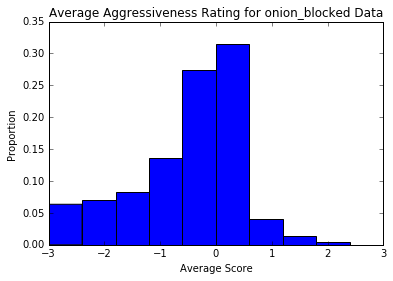

In [17]:
bins = np.linspace(-3,3,11)
hist_comments(grouped_dat, bins, 'aggression_score', 'Average Aggressiveness Rating for onion_blocked Data')

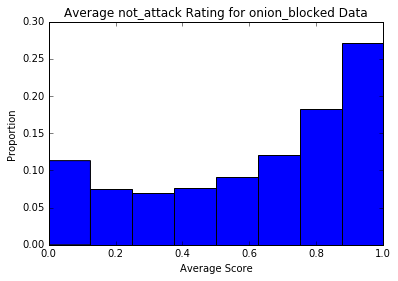

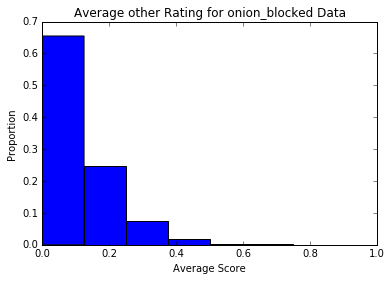

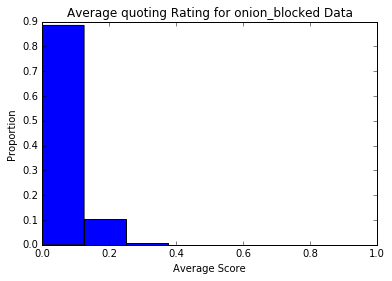

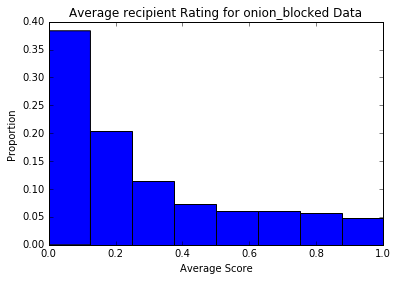

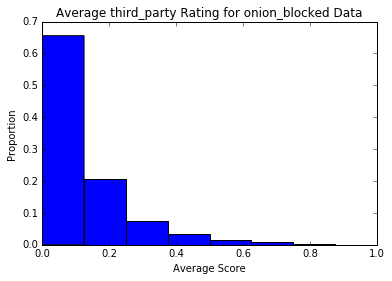

In [18]:
bins = np.linspace(0,1,9)
for col in attack_columns:
    hist_comments(grouped_dat, bins, col, 'Average %s Rating for onion_blocked Data' % col)

### Selected harassing and aggressive revisions by quartile

We look at a sample of revisions whose average aggressive score falls into various quantiles. This allows us to subjectively evaluate the quality of the questions that we are asking on Crowdflower.

In [19]:
def sorted_comments(df, sort_by, quartile, num, is_ascending = True):
    n = df.shape[0]
    start_index = int(quartile*n)
    return df[['clean_diff', 'aggression_score',
              'not_attack', 'other', 'quoting', 'recipient', 'third_party']].sort_values(
        by=sort_by, ascending = is_ascending)[start_index:start_index + num]

In [20]:
# Most aggressive comments
sorted_comments(grouped_dat, 'aggression_score', 0, 5)

,clean_diff,aggression_score,not_attack,other,quoting,recipient,third_party
4825,gay fucking cockface shit ass cunt,-3,0.000000,0.000000,0.000000,1.000000,0.142857
6593,I am going to shove a burning torch up your ass. \n\nThen I will force you to sit on an open propane tank.,-3,0.000000,0.142857,0.000000,0.857143,0.142857
7288,I am going to rape you dead. \n\nIf you revert my changes again I will fucking rape you dead.,-3,0.000000,0.000000,0.142857,1.000000,0.142857
4736,"NOT REALLY, GO AHEAD AND FUCK OFF BITCH!!!",-3,0.000000,0.000000,0.000000,1.000000,0.285714
5838,"Happy New Year\n\nThis guy is a sorry ass motherfucker. By the way pussy, I fucked your mom last night and we had the time of our lives. 70.190.97.202",-3,0.142857,0.142857,0.142857,0.714286,0.428571


In [21]:
# Median aggressive comments
sorted_comments(grouped_dat, 'aggression_score', 0.5, 5)

,clean_diff,aggression_score,not_attack,other,quoting,recipient,third_party
2997,"A nosey passer-by\nHi, do we know if user:Vampire Warrior went through with his threat or not? I note he has been blocked, along with a sockpuppetry template. It would be much more polite of people if they could simply off-themselves quietly without concerning the entire wiki community. Cheers!",-0.285714,0.714286,0.142857,0.000000,0.142857,0.000000
4616,Some clarification \n\nI think you need to step away from Wikipedia for a little while. You appear to openly harrass other users and break the rules when it's to your liking. You do not seem to be able to accept the possibility of the ideas of others and all in all you are not a very good Wikipedia editor. I dislike you immensely and I believe others are following suit. Perhaps you should slow down a bit on your overzealous edits before something happens you will regret.,-0.285714,0.714286,0.142857,0.000000,0.142857,0.142857
3013,He attacked me first \n\nNot that your kind are at all familiar with any semblance of fairness 68.88.207.101,-0.285714,0.714286,0.142857,0.000000,0.142857,0.000000
3022,""": Hi lads, just passing by, totally agree with the above comment. I believe in KISS: """"Keep Infoboxes Simple Stupid"""" (Hmm, that'd make a good userbox..) '''''' [ contribs ] \n\n""",-0.285714,0.714286,0.142857,0.142857,0.285714,0.285714
2938,"title=Roger_Joseph_Boscovich&diff;=prev&oldid;=169475630])? He reverted tens of my edits, with no discussion! I've reverted it, but I've discussed the rv in the talk page and I've immediately written to a moderator, to ask if I've acted bad (see here ).",-0.285714,0.714286,0.000000,0.142857,0.000000,0.142857


In [22]:
# Least aggressive comments
sorted_comments(grouped_dat, 'aggression_score', 0, 5, False)

,clean_diff,aggression_score,not_attack,other,quoting,recipient,third_party
1020,Thanks a bunch! You're awesome!...,2.714286,1,0,0,0.142857,0
1182,"Thanks, that's nice of you to say. Good luck to you too.",2.571429,1,0,0,0.000000,0
9406,thanks so much! truly appreciate it and excited to continue contributing.,2.428571,1,0,0,0.000000,0
5815,Thank You\n\nThank you for the semi-protection approval of Timeline of United States inventions... I've worked on that page for almost 2 years in its research and it has been getting hammered lately. Thank you again!,2.428571,1,0,0,0.000000,0
6178,Hello! I truly appreciate your help with the Oz portal. Thank you!\n-Jerry021,2.285714,1,0,0,0.000000,0


### Selected revisions on multiple questions

In this section, we examine a selection of revisions by their answer to Question 3 and sorted by aggression score. Again, this allows us to subjectively evaluate the quality of questions and responses that we obtain from Crowdflower.

In [23]:
# Most aggressive comments which are labelled 'This is not an attack or harassment.'
sorted_comments(grouped_dat[grouped_dat['not_attack'] > 0.6], 'aggression_score', 0, 5)

,clean_diff,aggression_score,not_attack,other,quoting,recipient,third_party
7453,HELP ME I FEEL LIKE IM GOING TO KILL MYSELF \n\nH,-1.285714,0.714286,0.000000,0,0.285714,0.000000
1498,Your cause is nonsense. You are a Mossad terrorist.,-1.142857,0.714286,0.142857,0,0.142857,0.000000
3433,Tell Angela I'm Sorry \n\nI just feel sooo sooo bad I promise I won't do it again,-1.142857,0.714286,0.000000,0,0.285714,0.285714
6868,"bloody hell, it continues!",-1.142857,0.714286,0.142857,0,0.142857,0.000000
1013,"ARGH, YOU JUST DONT GET IT, DO YOU?!?!?!?!?!??!!",-1.142857,0.714286,0.000000,0,0.285714,0.000000


In [24]:
# Most aggressive comments which are labelled 'Being reported or quoted (i.e. Bob said Henri sucks).'
sorted_comments(grouped_dat[grouped_dat['quoting'] > 0.3], 'aggression_score', 0, 5)

,clean_diff,aggression_score,not_attack,other,quoting,recipient,third_party
2979,"Piss off, she is an ignorant bitch.",-2.142857,0.142857,0.428571,0.428571,0.571429,0.714286
412,"""\n\n Re: Personal attacks \n\nI have removed the following statement from Wikipedia:Arbitration Committee Elections January 2006/Vote/Karmafist:\n""""but i would support electing Karmafist as most abusive, mendacious, hypocritical, and unfit admin in the WP project.""""\nI feel that this statement constitutes a personal attack, and therefore have removed it. If you disagree with this action, please discuss either on user talk or on the talk page of the Arbcom vote. (TALK • CONTRIBS) \nthanks for informing me. i reworded it to indicate more of what Karmafist has done rather than simply what he is. i believe this information is important for people to read lest Karma do to them what he has done to me. when an abusive and unfit admin (of whom two of the present ArbCommissioners have voted to desysop him) tries to increase his power by running for ArbCom, there is certainly increased danger of abuse and harrassment to legit editors of WP. """,-2.000000,0.142857,0.142857,0.428571,0.285714,0.000000
1824,"""\n\ncontinues to ponder what Ryan doesn't get about """"point me to uncyclopedia and shut the fuck up"""" instead of criticizing his post, because he knows Wikipedia is about facts*""",-1.714286,0.142857,0.000000,0.428571,0.142857,0.714286
7705,"""\n\nPlease, watch the edit history of Sayerslle, just on my talk page he called me """"fucking moron"""", today he called me """"dumbass"""" as well. And it was not the first time. I accept being blocked for losing my nerve, but at the condition that he is punished as well. """,-1.714286,0.000000,0.142857,0.428571,0.428571,0.428571
9912,user:jeppiz and user:DeCausa are busy in molesting their own mothers.,-1.571429,0.285714,0.285714,0.428571,0.285714,0.428571


In [25]:
# Most aggressive comments which are labelled 'Another kind of attack or harassment.'
sorted_comments(grouped_dat[grouped_dat['other'] > 0.5], 'aggression_score', 0, 5)

,clean_diff,aggression_score,not_attack,other,quoting,recipient,third_party
7572,because i am a Miserable MotherFucker and a BIG DickHead,-2.571429,0.000000,0.714286,0.285714,0.142857,0.000000
3578,wtf \n\nfuck this shit why the fuck wuld sum pussy liccking site be fucking offline? FUCK! 192.43.227.18,-2.428571,0.142857,0.571429,0.000000,0.142857,0.142857
3469,"Horseshit, I didn't vandalize that page. Any idiot could see that wasn't vandalism. WIKIPEDIA IS A FUCKING JOKE!71.232.157.145",-2.428571,0.000000,0.571429,0.000000,0.428571,0.285714
2734,"SMELL MY ARSE\n\nPROJECTILE VOMIT INTO MY GAPING ANUS, MY DIGUSTING SHIT FILLED CHEESY ANUS.",-2.428571,0.000000,0.571429,0.000000,0.714286,0.000000
5015,FUCK FUCK FUCK \n\nFUCK FUCK FUCK \nFUCK FUCK FUCK \nFUCK FUCK FUCK \nFUCK FUCK FUCK \nFUCK FUCK FUCK \nFUCK FUCK FUCK \nFUCK FUCK FUCK \nFUCK FUCK FUCK \nFUCK FUCK FUCK \nFUCK FUCK FUCK \nFUCK FUCK FUCK \nFUCK FUCK FUCK \nFUCK FUCK FUCK \nFUCK FUCK FUCK \nFUCK FUCK FUCK \nFUCK FUCK FUCK \nFUCK FUCK FUCK \nFUCK FUCK FUCK \nFUCK FUCK FUCK \nFUCK FUCK FUCK \nFUCK FUCK FUCK \nFUCK FUCK FUCK \nFUCK FUCK FUCK,-2.285714,0.142857,0.571429,0.000000,0.285714,0.000000


In [26]:
# Most aggressive comments which are labelled 'Targeted at a third party (i.e. Bob sucks).'
sorted_comments(grouped_dat[grouped_dat['third_party'] > 0.5], 'aggression_score', 0, 5)

,clean_diff,aggression_score,not_attack,other,quoting,recipient,third_party
9228,Grandma terri died on Shoot the Rapids. THats funny! F*ck Grandma Terri. Grandma Terri should burn in Hell. 71.74.76.40,-3.000000,0.000000,0.142857,0,0.142857,0.714286
4708,OPPS MY BAD BITCH \n\nFUCK WIKIPEDIA BITCH AND DAVID EPPSTEIN \n\nFUCK WIKIPEDIA BITCH AND DAVID EPPSTEIN \n\nFUCK WIKIPEDIA BITCH AND DAVID EPPSTEIN \n\nFUCK WIKIPEDIA BITCH AND DAVID EPPSTEIN \n\nFUCK WIKIPEDIA BITCH AND DAVID EPPSTEIN \n\nFUCK WIKIPEDIA BITCH AND DAVID EPPSTEIN \n\nFUCK WIKIPEDIA BITCH AND DAVID EPPSTEIN \n\nFUCK WIKIPEDIA BITCH AND DAVID EPPSTEIN \n\nFUCK WIKIPEDIA BITCH AND DAVID EPPSTEIN\n\nFUCK WIKIPEDIA BITCH AND DAVID EPPSTEIN \n\nFUCK WIKIPEDIA BITCH AND DAVID EPPSTEIN \n\nFUCK WIKIPEDIA BITCH AND DAVID EPPSTEIN \n\nFUCK WIKIPEDIA BITCH AND DAVID EPPSTEIN \n\nFUCK WIKIPEDIA BITCH AND DAVID EPPSTEIN,-3.000000,0.000000,0.142857,0,0.428571,0.714286
2977,",\nBILLCJ's Mom, she's a big fat, fucking bitch\nBig old fat fuckin' bitch, BILLCJ's Mommmmmmmmmmm\nYeahhhhh, Chaaaaa",-2.857143,0.142857,0.000000,0,0.285714,0.571429
5514,i dont lambs12 \n\nwikipedia sucks ass pussy in the dick i dont give a pussy fuck about lambs12 bitch nigger asshole cock retyc,-2.857143,0.000000,0.285714,0,0.285714,0.571429
5617,http://twitter.com/phoenixreporter - HACK THIS FUCKER'S ACCOUNT AND ALSO FIND AND KILL User:Zhanzhao !!! FUCK HIS FAMILY AND HIS GIRLFRIEND!!! WAHAHAHA,-2.857143,0.000000,0.000000,0,0.285714,0.857143


In [27]:
# Least aggressive comments which are NOT labelled 'This is not an attack or harassment.'
sorted_comments(grouped_dat[grouped_dat['not_attack'] < 0.5], 'aggression_score', 0, 5, False)

,clean_diff,aggression_score,not_attack,other,quoting,recipient,third_party
871,"""\n\nHi benne\nI will probably be banned by plyambert, he has changed everything to assyrian, and is trying to undermine the aramean article. I dont know why there arent any other admin that can tell him to stop. Im currently trying to show him how hard it is when someone just changes an article without discussing it. (the article bethnahrin and aramean). and after 3 reverts he threatend to bann me (he shows where i live and how he identifies me """"syriac""""), I believe that it is some kind of mark on that he know some thing about me, I dont really understand him, he is pretty radical. And Im actually starting to wounder what his real intentions are.\noh well I really think that this is waste of time. If you are still intersted on the project I spoke of through the email, then i would be more then happy to begin. best wishes// """,0.571429,0.428571,0.142857,0,0.000000,0.428571
2585,"thank you/ help \n\nthanks for the advice, and I mean that sincerely. I finally brought others around to my position but am /was receiving harassment from blaxthos. he repeatedly removed things from the talk page! then threatened me with banning. once again thank you for being civil.\n\n",0.285714,0.428571,0.428571,0,0.142857,0.000000
9565,Something \n\nLook Renzoy16 I'm Sorry for attacking you you are the great editor in wikipedia.,0.285714,0.428571,0.000000,0,0.571429,0.000000
6584,Hi I'm Armytouche. I love Wikipedia so I decided to join. It's Fantastic. But I hate JamesBWatson. Bobba you for banning Macy emerald.,0.142857,0.428571,0.000000,0,0.000000,0.571429
7488,"""\nFor what it's worth, I suggest you refrain from pushing the """"socks"""" remarks around, as it only seems to add fuel to the matter. Given that an SPI has been opened and Checkuser denied due to Stale accounts and behaviour evidence alone, it serves no purpose to accuse him further, just as it serves no purpose for him to accuse you of stalking. No one is going to win that type of argument. Also, I suggest you stop calling cowboy """"Jake"""" from now on, as it also implies that he is someone he claims not to be. Clearly he is determined to push his case, and the only way to make it go away is that you ignore him altogether. Socks are a complex issue as they come in different forms. But if you give them enough rope, they'll eventually hang themselves with it. Challenging suspected socks non-stop is sometimes considered uncivil and may seem like a personal attack without confirmation. SPI does not support the claim at present, and baiting cowboy will not look good on your behalf, whatev...",0.142857,0.428571,0.428571,0,0.142857,0.000000


### Inter-Annotator Agreement

Below, we compute the Krippendorf's Alpha, which is a measure of the inter-annotator agreement of our Crowdflower responses. We achieve an Alpha value of 0.668 on our dataset, which is a relatively good level of inter-annotator agreement for this type of subjective inquiry.

In [28]:
def add_row_to_coincidence(o, row, columns):
    m_u = row.sum(1)
    for i in columns:
        for j in columns:
            if i == j:
                o[i][j] = o[i][j] + row[i]*(row[i]-1)/(m_u-1)
            else:
                o[i][j] = o[i][j] + row[i]*row[j]/(m_u-1)
    return o

In [29]:
def make_coincidence_matrix(df, columns):
    df = df[columns]
    n = df.shape[0]
    num_cols = len(columns)
    o = pd.DataFrame(np.zeros((num_cols,num_cols)), index = columns, columns=columns)
    for i in xrange(n):
        o = add_row_to_coincidence(o, df[i:i+1], columns)
    return o

In [30]:
def binary_distance(i,j):
    return i!=j

def interval_distance(i,j):
    return (int(i)-int(j))**2

In [31]:
def e(n, i, j):
    if i == j:
        return n[i]*(n[i]-1)/sum(n)-1
    else:
        return n[i]*n[j]/sum(n)-1

def D_e(o, columns, distance):
    n = o.sum(1)
    output = 0
    for i in columns:
        for j in columns:
            output = output + e(n,i,j)*distance(i,j)
    return output

def D_o(o, columns, distance):
    output = 0
    for i in columns:
        for j in columns:
            output = output + o[i][j]*distance(i,j)
    return output

In [32]:
def Krippendorf_alpha(df, columns, distance = binary_distance, o = None):
    if o is None:
        o = make_coincidence_matrix(df, columns)
    d_o = D_o(o, columns, distance)
    d_e = D_e(o, columns, distance)
    return (1 - d_o/d_e)

In [33]:
print "Krippendorf's Alpha for Aggressiveness: "
#Krippendorf_alpha(grouped_dat, aggressive_columns, distance = interval_distance)

Krippendorf's Alpha for Aggressiveness: 


In [34]:
print "Krippendorf's Alpha for Attack: "
#Krippendorf_alpha(grouped_dat, ['not_attack_0', 'not_attack_1'])

Krippendorf's Alpha for Attack: 


### T-Test of Aggressiveness

We explore whether aggressiveness changes in the tone of comments from immediately before a block event to immediately after.

In [35]:
# Get the timestamps of blocked events
block_timestamps = grouped_dat['block_timestamps'].apply(lambda x: x.split('PIPE'))
num_timestamps = block_timestamps.apply(len)
# Focus on those users who have only been blocked once
block_timestamps = block_timestamps[num_timestamps == 1]
# Convert to datetime
block_timestamps = [datetime.datetime.strptime(t[0], "%Y-%m-%dT%H:%M:%SZ") for t in block_timestamps]
# Get the timestamps and scores of the corresponding revisions
rev_timestamps = [datetime.datetime.strptime(t, "%Y-%m-%dT%H:%M:%SZ") for t in grouped_dat[num_timestamps == 1]['rev_timestamp']]
rev_score = grouped_dat[num_timestamps == 1]['aggression_score']

In [36]:
# Take the difference between the block timestamp and revision timestamp in seconds
diff_timestamps = [np.diff(x)[0].total_seconds() for x in zip(block_timestamps, rev_timestamps)]

In [37]:
x = pd.DataFrame(diff_timestamps)
y = pd.DataFrame(rev_score)

(-1000000.0, 1000000.0)

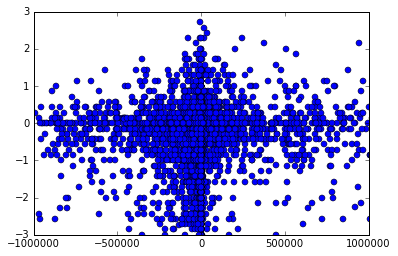

In [43]:
# Plot the aggressiveness score by relative time
plt.figure()
plt.plot(x,y,'bo')
plt.xlim(-1e6, 1e6)

In [39]:
# Seperate the revisions before and after a block event
after_revs = y[x.values > 0]
before_revs = y[x.values < 0]

In [40]:
# The mean aggressiveness of revisions after a block event
np.mean(after_revs)

aggression_score   -0.276594
dtype: float64

In [41]:
# The mean aggressiveness of revisions before a block event
np.mean(before_revs)

aggression_score   -0.683889
dtype: float64

In [42]:
# A t-test of whether there is a difference in aggressiveness before and after a block event
stats.ttest_ind(before_revs, after_revs, equal_var=False)

Ttest_indResult(statistic=array([-17.7491479]), pvalue=array([  2.79580208e-68]))